In [1]:
from models_files.d3unet_import4 import d3UNet
from utils.multiple_hits_utils import  read_multiple_hits
import numpy as np
import h5py
from utils.metrics import dice_coef
import tensorflow as tf

## Sanity check of one example

In [7]:
en1 = 20
en2 = 24
num_runs = 500
name = 'center_%.1fGeV_outside_%.1f_%iruns' %(en1, en2, num_runs)
images, labels, my_dict = read_multiple_hits('simulations/multiple_hits/', name, 
                                             add_noise=False, read_dict=True)
images.shape

print(images.shape)

(500, 32, 48, 48, 1)


In [9]:
print(my_dict['451'])

{'run': 451, 'energy1': 20.0, 'energy2': 24.0, 'particle 2 center': (5.0, 3.0), 'center_differences': 5.830951894845301}


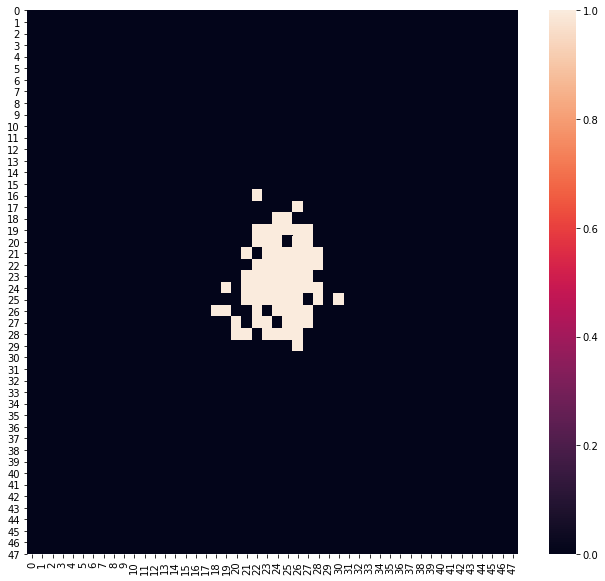

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.figure(figsize=(11,10))
sns.heatmap(labels[451, 15, :, :, 0])
plt.show()

## Define model

In [25]:
img_depth, img_width, img_height, img_channels = 32, 48, 48, 1

model = d3UNet(img_depth, img_width, img_height, img_channels, 1)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics = [dice_coef])

# checkpoint
filepath = "models_saved/unet-3d-64/unet3d_trial1-dice{val_dice_coef:.4f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=False, mode='max')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', min_delta=0.0, verbose=1, mode='max')
csv_logger = tf.keras.callbacks.CSVLogger("models_history/3dunet_history_log.csv", append=True)
callbacks_list = [checkpoint, csv_logger]

In [16]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 40, 40,  0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv3D)                (None, 32, 40, 40, 3 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2_28 (Batc (None, 32, 40, 40, 3 128         Conv1_1[0][0]                    
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 32, 40, 40, 3 0           batch_normalization_v2_28[0][0]  
____________________________________________________________________________________________

## Training process

In [17]:
num_iters = 1
energies = np.arange(20, 36, 4)
num_runs = 5
best_val_dice_coef = 0.0

train_start = 0
train_end = 4

for n in range(num_iters):
    print('Iter:', n+1)
    multiple_images = np.zeros((1, 32, 48, 48, 1))
    multiple_labels = np.zeros((1, 32, 48, 48, 1))
    
    filepath = 'models_saved/unet-3d-64/unet3d_trial1-iter%i-dice{val_dice_coef:.4f}.h5' %(n+1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=False, mode='max')
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', min_delta=0.0, verbose=1, mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger("models_history/3dunet_history_log.csv", append=True)
    callbacks_list = [checkpoint, csv_logger]
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics = [dice_coef])
    
    print(filepath)
    
    for en1 in energies:
        print('Energy 1:', en1)
        for en2 in energies:
            if en1 != en2:
                print('Energy 2:', en2)
                name = 'center_%.1fGeV_outside_%.1f_%iruns' %(en1, en2, num_runs)
                images, labels, _ = read_multiple_hits('simulations/multiple_hits/', name, add_noise=True)
                images = images[train_start: train_end, :, 8:56, 8:56, :]
                labels = labels[train_start: train_end, :, 8:56, 8:56, :]
                
                multiple_images = np.concatenate((multiple_images, images))
                multiple_labels = np.concatenate((multiple_labels, labels))
    multiple_images = multiple_images[1:]
    multiple_labels = multiple_labels[1:]
    train_start += 1
    train_end += 1
    
    random_mask = np.arange(multiple_images.shape[0])
    np.random.shuffle(random_mask)
    
    multiple_images = multiple_images[random_mask]
    multiple_labels = multiple_labels[random_mask]
    print(multiple_images.shape)
    
    history = model.fit(multiple_images, multiple_labels, 
              batch_size=1, 
              epochs=1,
              validation_split=0.1,
              shuffle=True,
              callbacks=callbacks_list)



Iter: 1
models_saved/unet-3d-64/unet3d_trial1-iter1-dice{val_dice_coef:.4f}.h5
Energy 1: 20
Energy 2: 24
Energy 2: 28
Energy 2: 32
Energy 1: 24
Energy 2: 20
Energy 2: 28
Energy 2: 32
Energy 1: 28
Energy 2: 20
Energy 2: 24
Energy 2: 32
Energy 1: 32
Energy 2: 20
Energy 2: 24
Energy 2: 28
(48, 32, 48, 48, 1)
Train on 43 samples, validate on 5 samples
42/43 [============================>.] - ETA: 3s - loss: 0.1623 - dice_coef: 0.1961
Epoch 00001: saving model to models_saved/unet-3d-64/unet3d_trial1-iter1-dice0.0006.h5
43/43 [==============================] - 143s 3s/sample - loss: 0.1601 - dice_coef: 0.1996 - val_loss: 96.6705 - val_dice_coef: 6.3878e-04


## Progressive loading

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# create a data generator
datagen = ImageDataGenerator()

In [ ]:
train_it = datagen.flow_from_directory('data/train/', class_mode='binary', batch_size=64)
val_it = datagen.flow_from_directory('data/validation/', class_mode='binary', batch_size=64)
test_it = datagen.flow_from_directory('data/test/', class_mode='binary', batch_size=64)

In [ ]:
model.fit_generator(train_it, steps_per_epoch=16, validation_data=val_it, validation_steps=8)

# TRAINING TILL THIS POINT

In [60]:
history.history['val_dice_coef'][0]

0.0005628824

In [61]:
best_val_dice_coef

0.23570447

# DEMONSTRATE ON ONE IMAGE

In [192]:
model = tf.keras.models.load_model('models_saved/unet-3d-64/unet3d_trial4-gpu-iter2-dice0.9200.h5', 
                                   custom_objects={'dice_coef' : dice_coef})

In [18]:
run = 0
test_labels = labels[run]
test_labels = np.expand_dims(test_labels, axis=0)

test_images = images[run]
test_images = np.expand_dims(test_images, axis=0)
print('Test images and labels shape:', test_labels.shape)

test_pred = model.predict(test_images)
print('Test predictions shape:', test_pred.shape)
# pred_2d_np = pred_2d.numpy()

Test images and labels shape: (1, 32, 48, 48, 1)
Test predictions shape: (1, 32, 48, 48, 1)


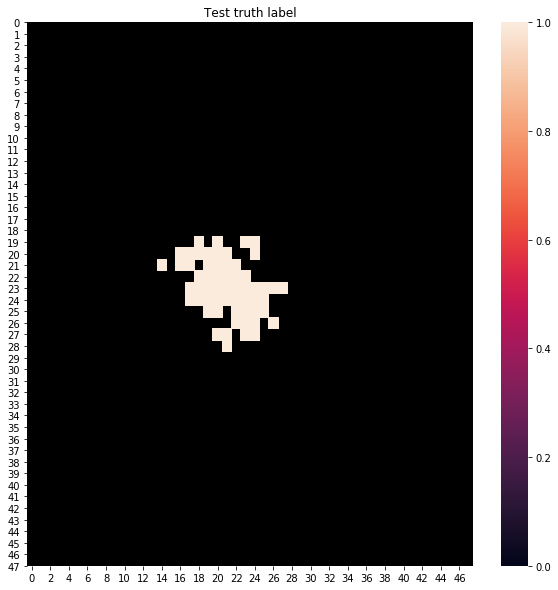

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

lay = 25; num = 0
pred_2d = test_pred[num, lay, :, :, 0]
label_2d = test_labels[num, lay, :, :, 0]
image_2d = test_images[num, lay, :, :, 0]

# Plot test label
%matplotlib inline
plt.figure(figsize=(10,10))
mask = label_2d == 0.0
ax = sns.heatmap(label_2d, mask=mask, fmt=".2")
ax.set_facecolor("black")
plt.title("Test truth label")
plt.show()

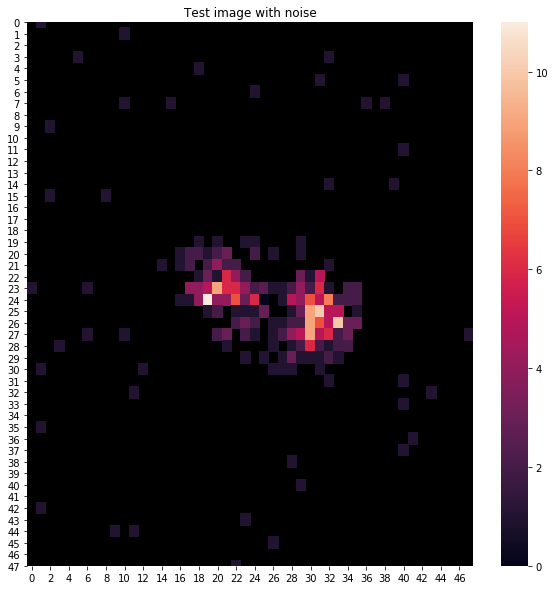

In [20]:
# Plot test image
plt.figure(figsize=(10,10))
mask = image_2d == 0.0
ax = sns.heatmap(image_2d, mask=mask, fmt=".2")
ax.set_facecolor("black")
plt.title("Test image with noise")
plt.show()

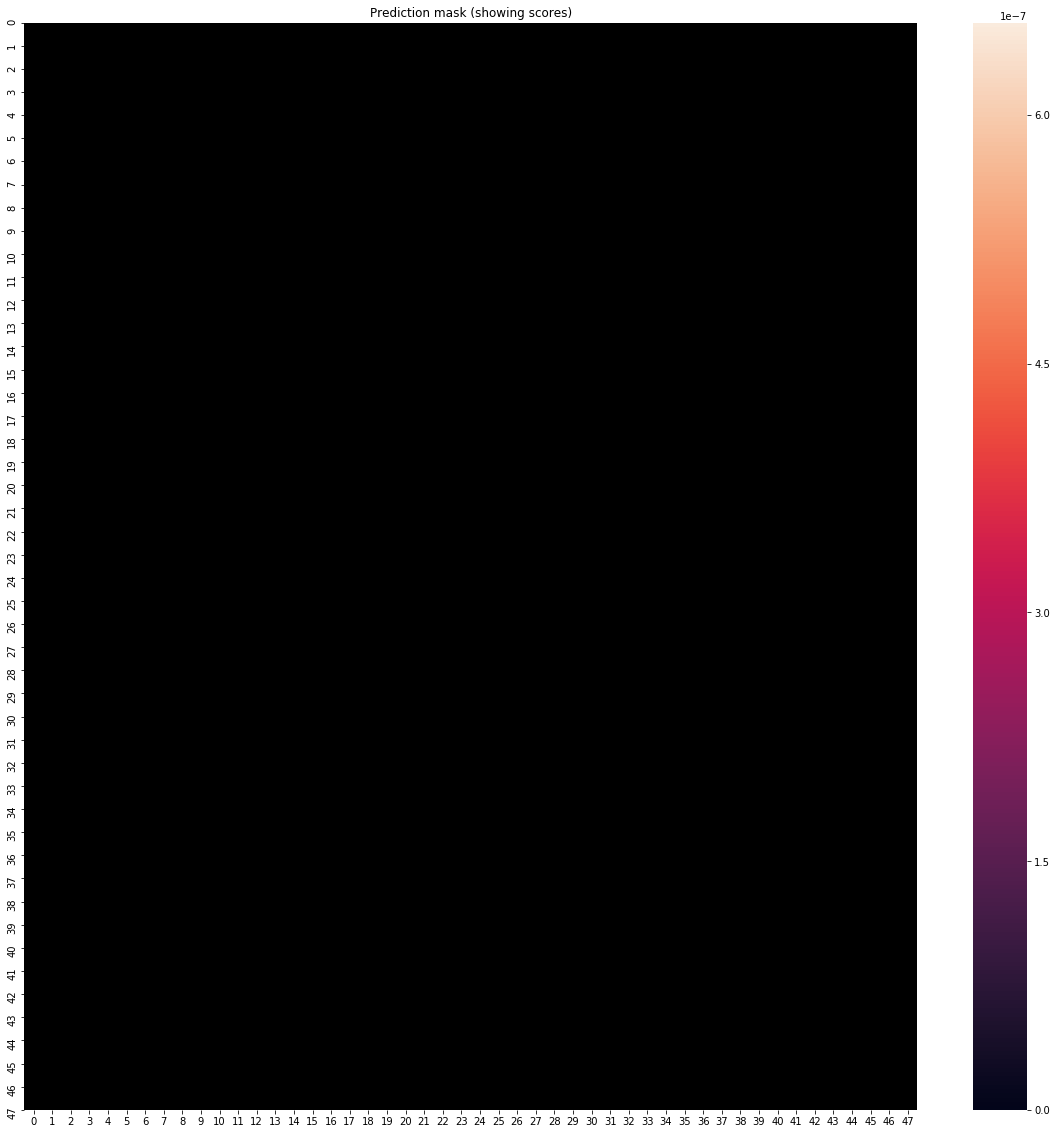

In [21]:
# plot prediction mask
plt.figure(figsize=(20,20))
mask = pred_2d < 0.5
ax = sns.heatmap(pred_2d, mask=mask, fmt=".2",annot=True)
ax.set_facecolor("black")
plt.title("Prediction mask (showing scores)")
plt.show()

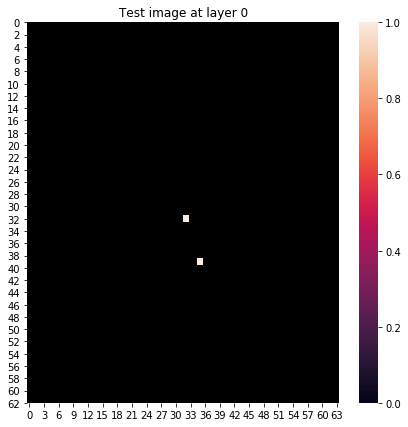

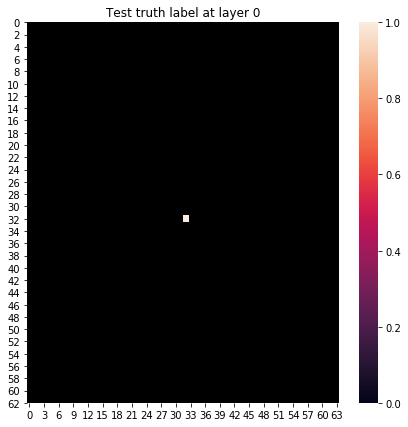

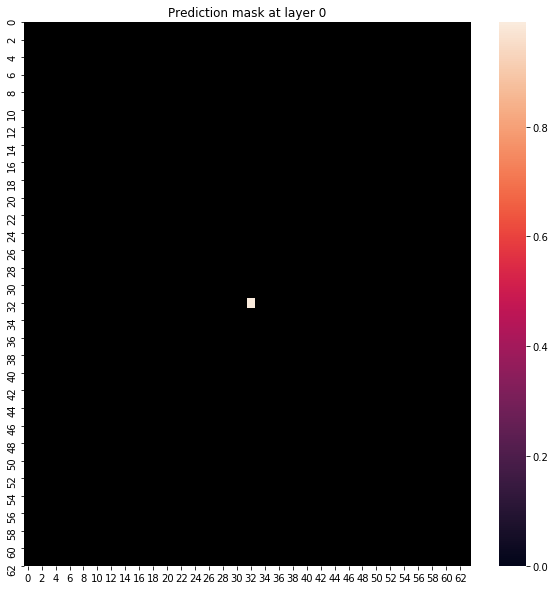

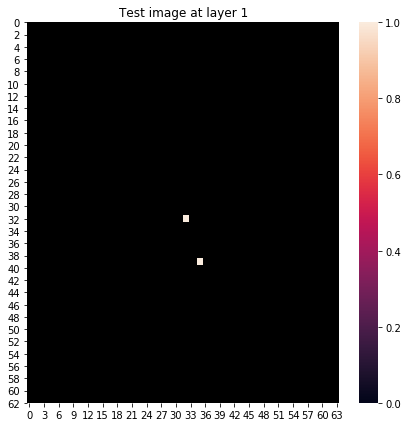

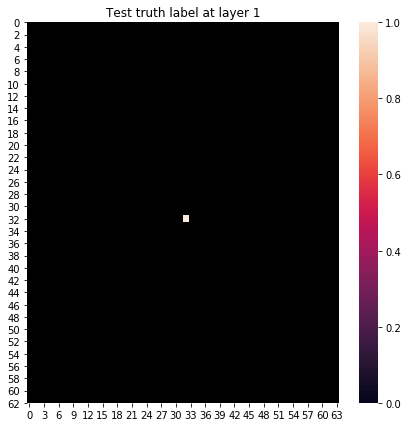

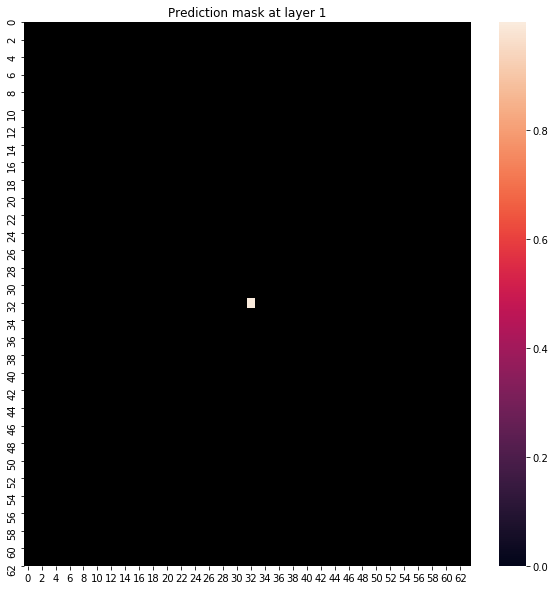

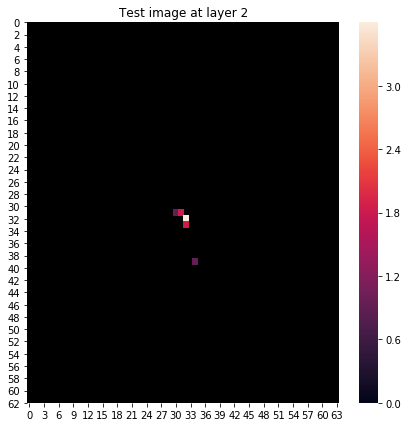

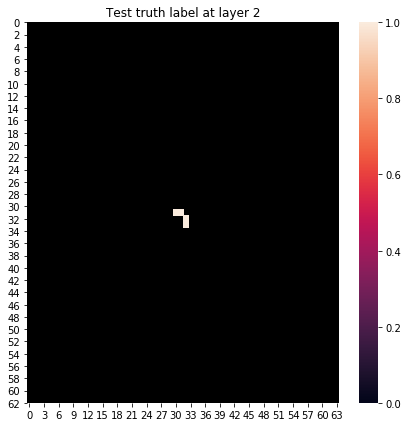

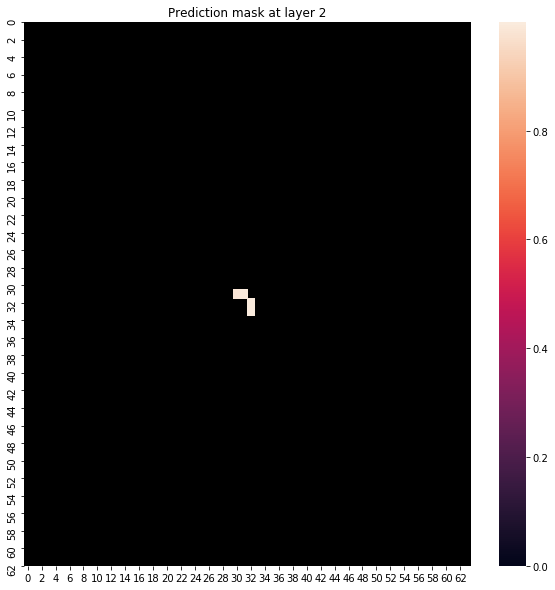

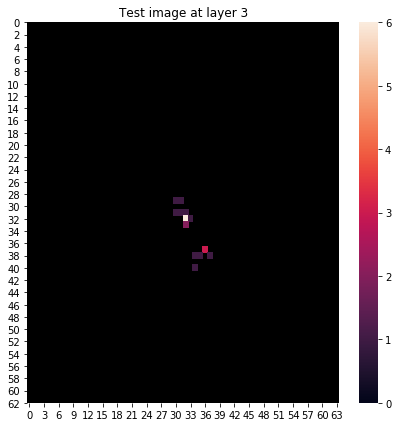

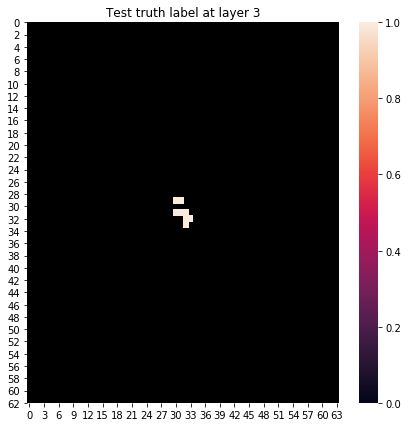

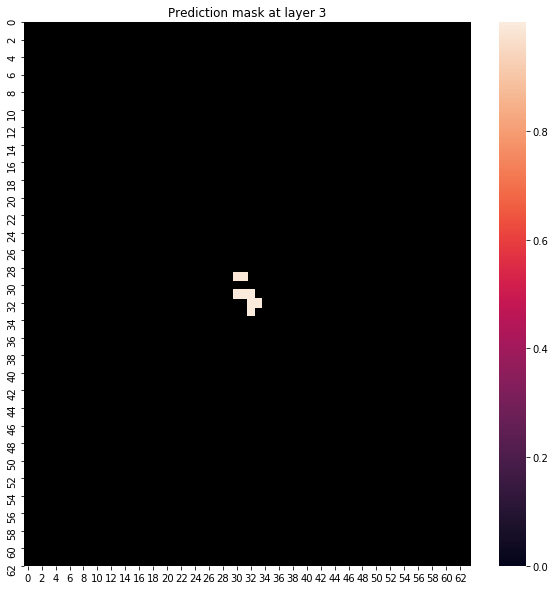

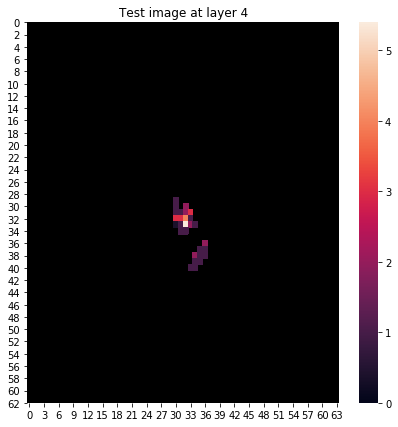

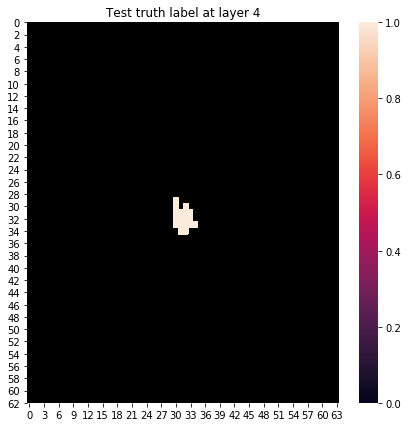

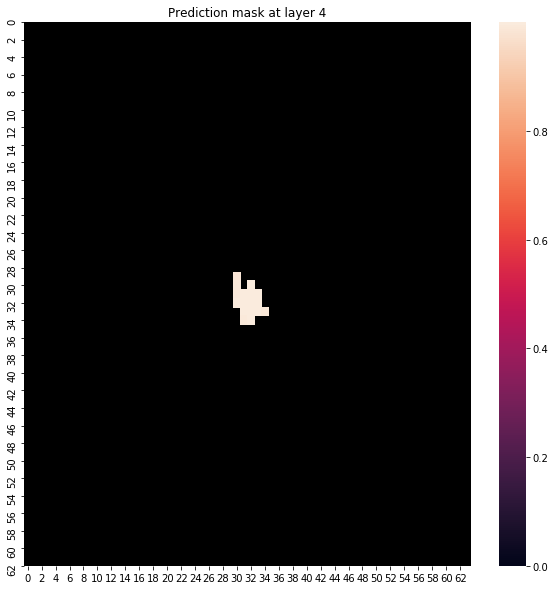

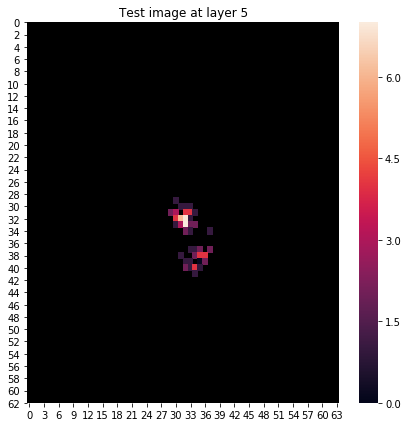

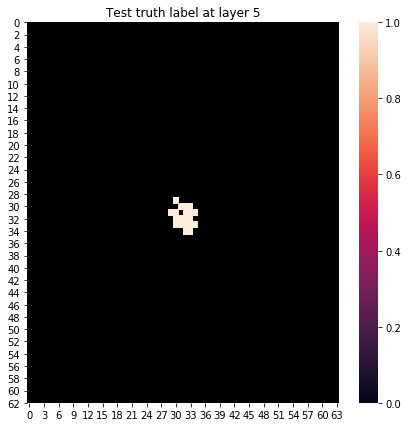

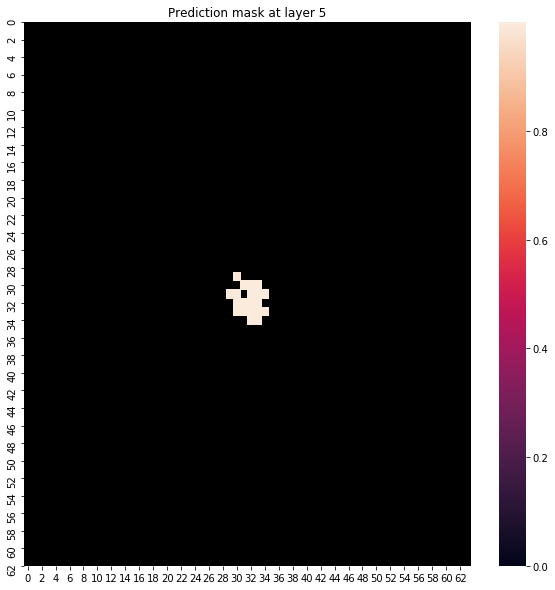

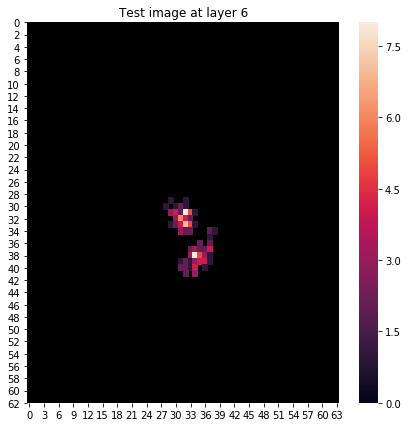

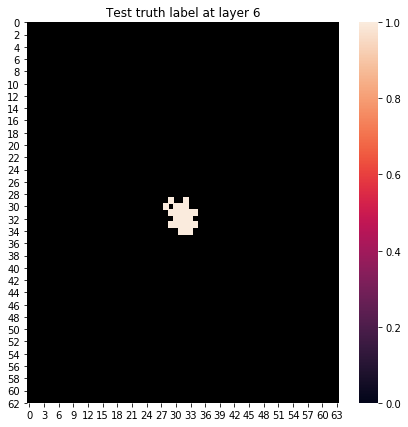

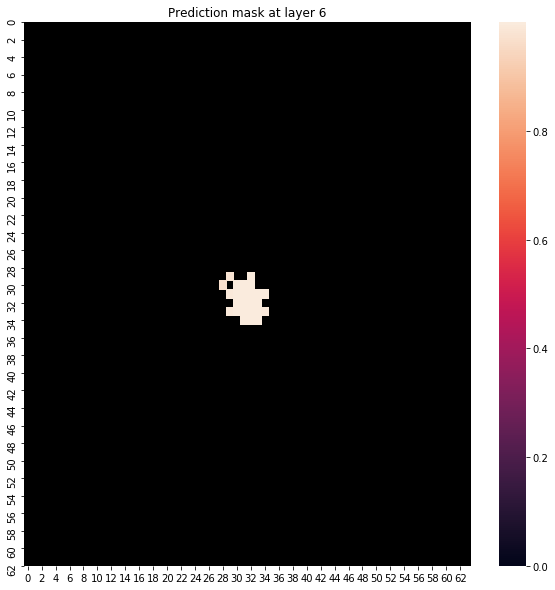

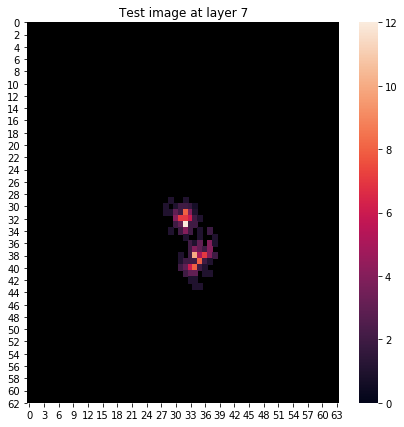

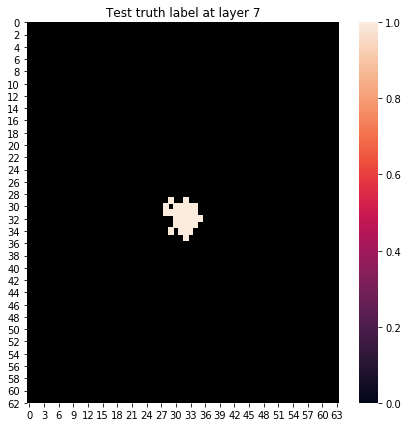

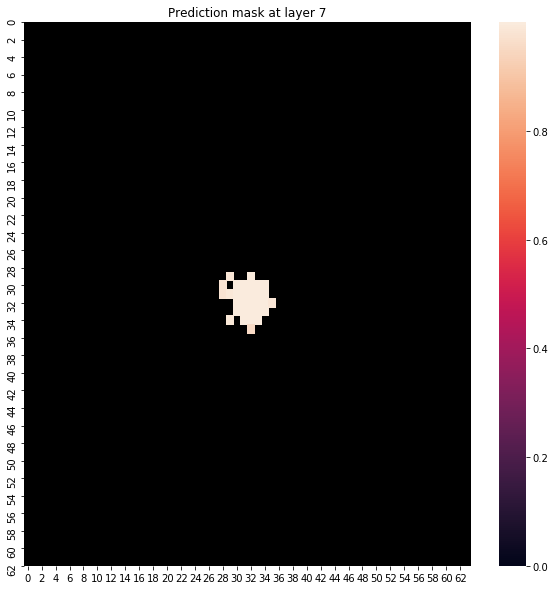

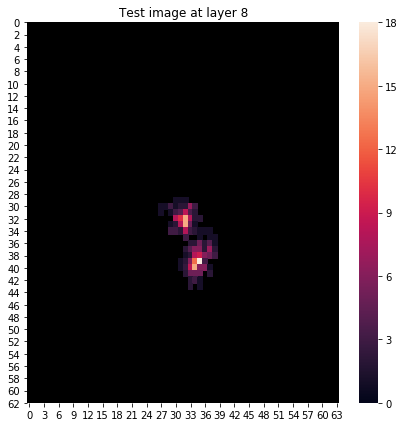

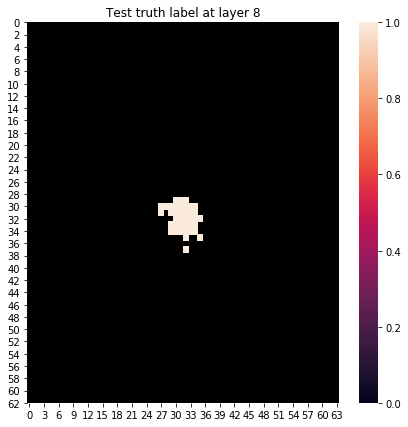

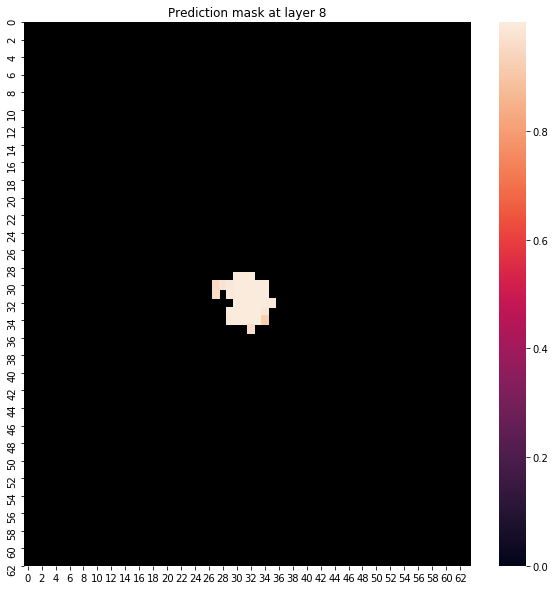

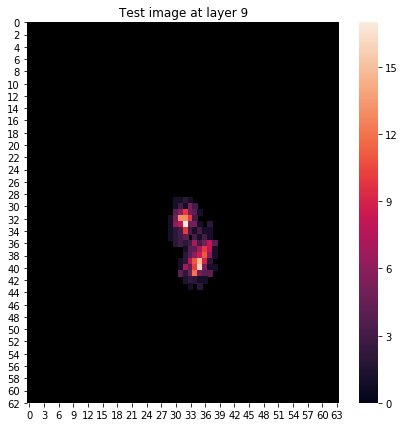

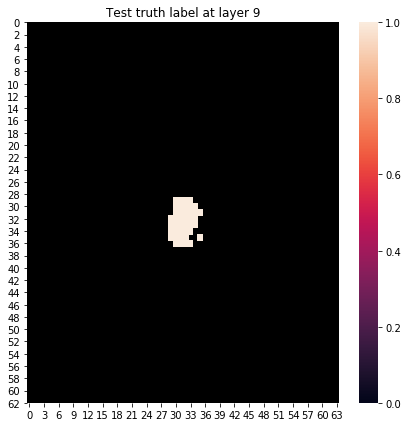

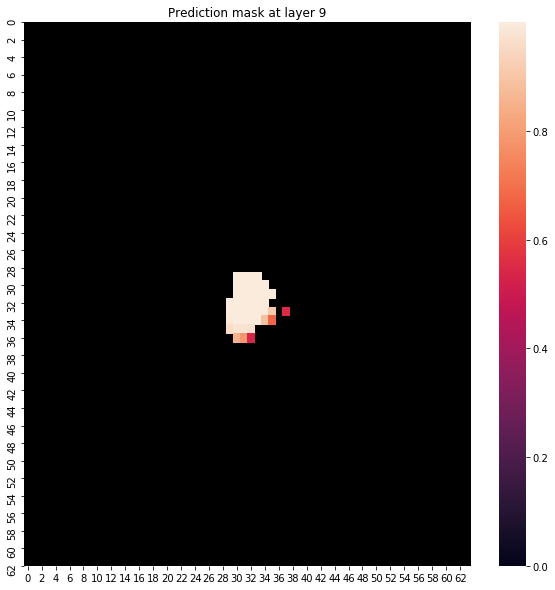

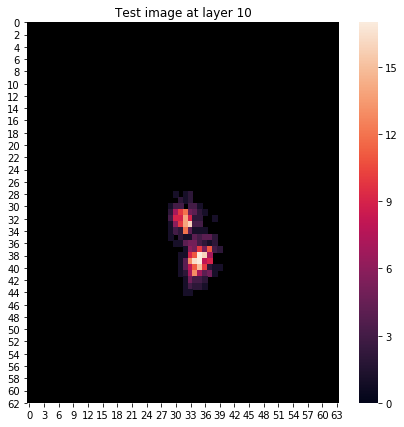

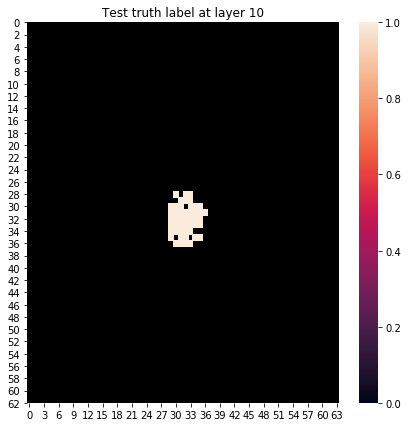

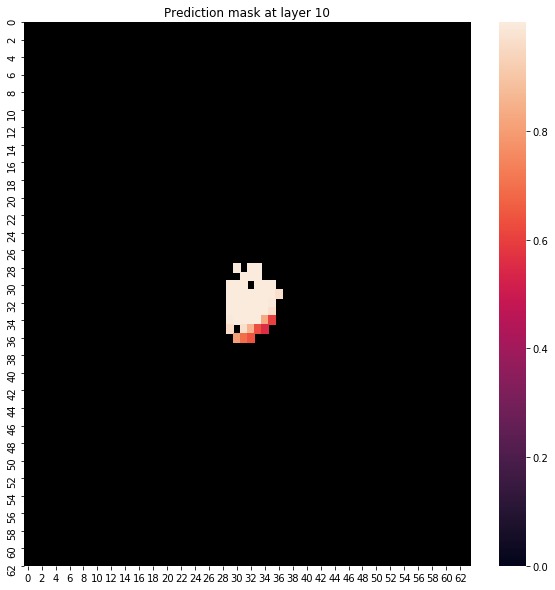

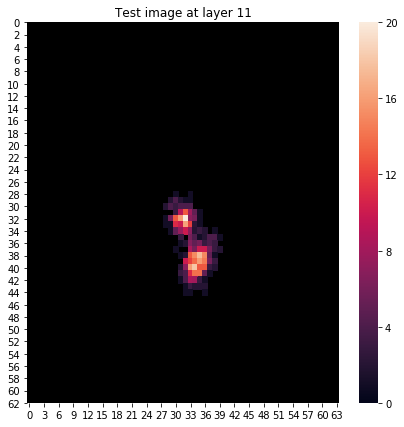

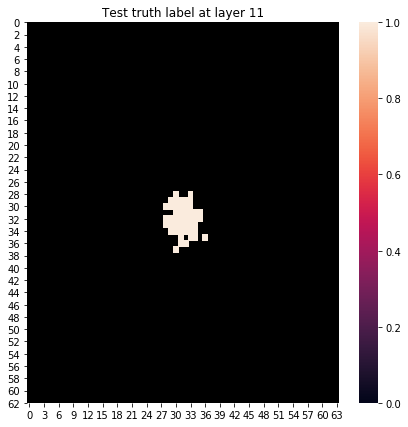

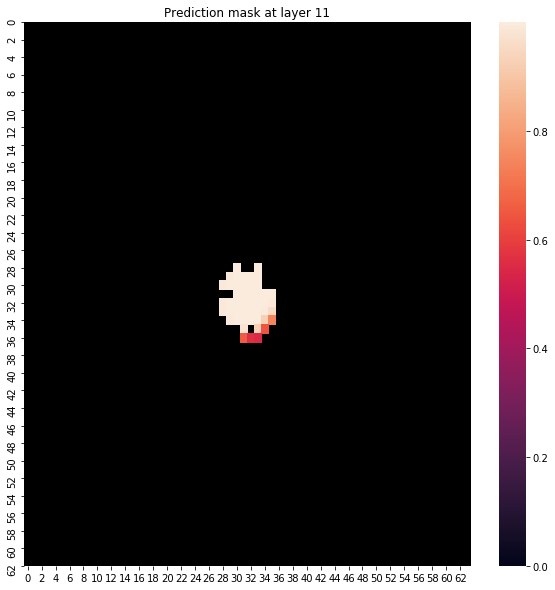

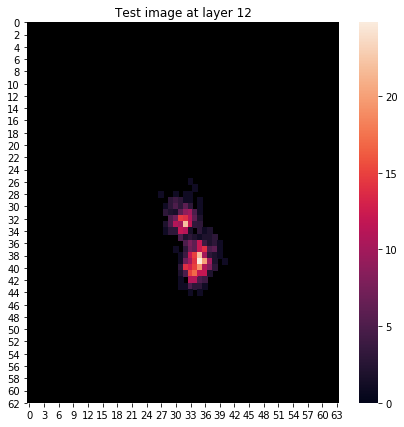

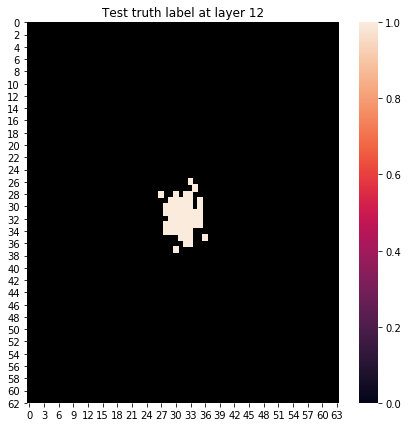

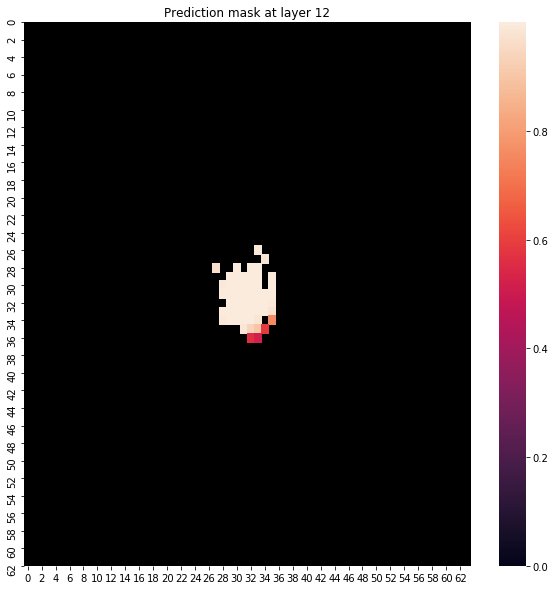

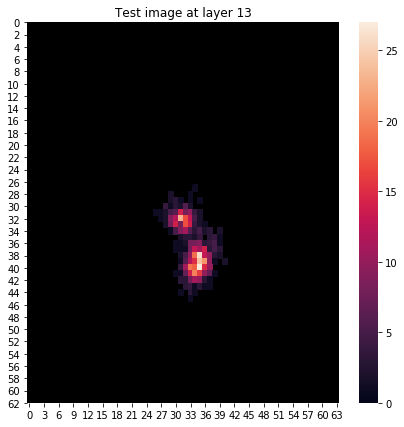

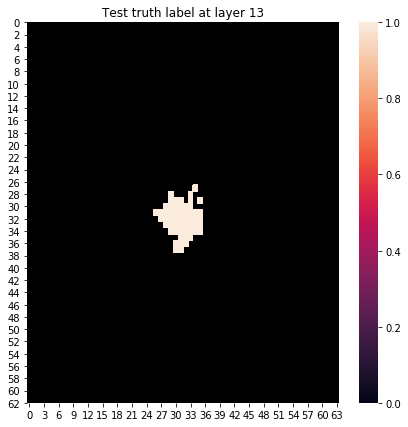

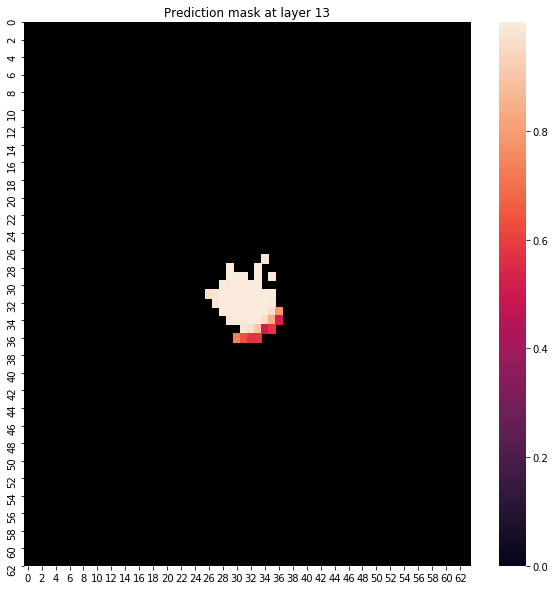

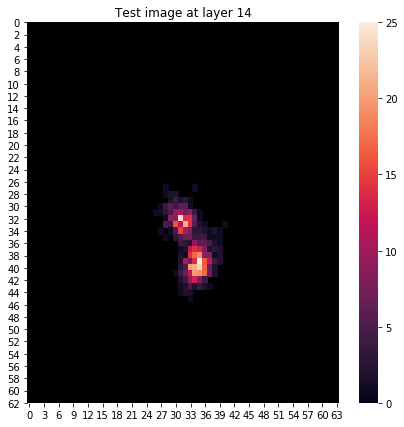

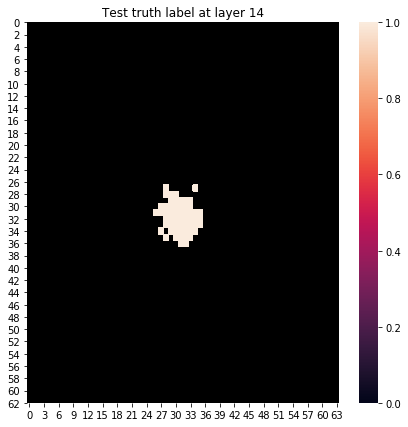

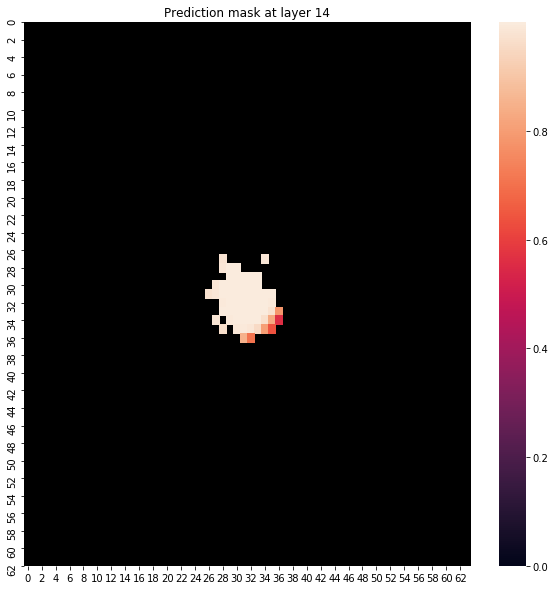

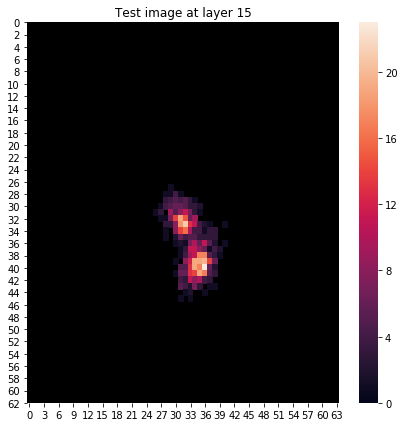

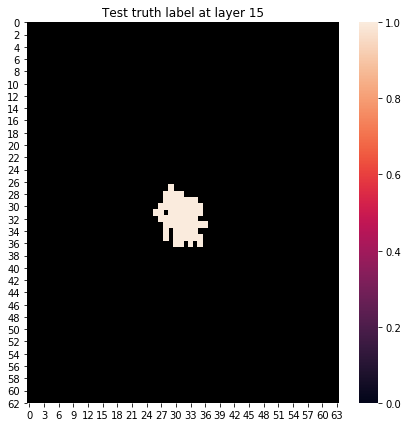

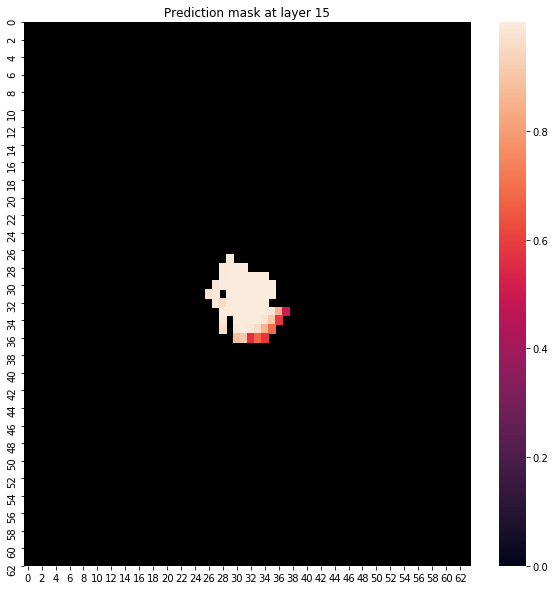

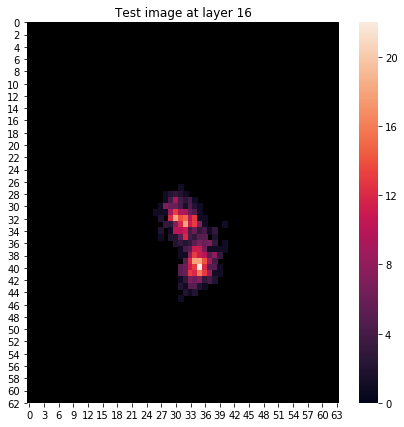

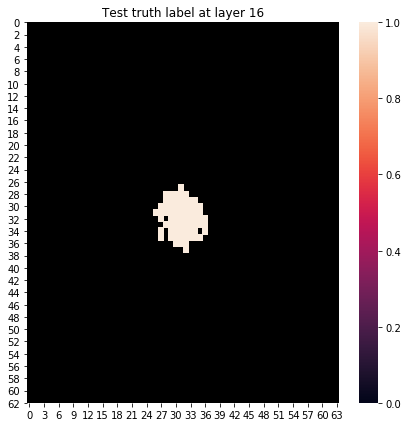

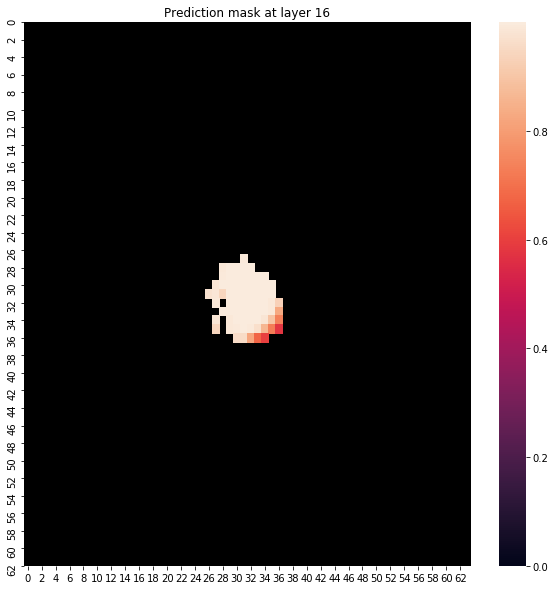

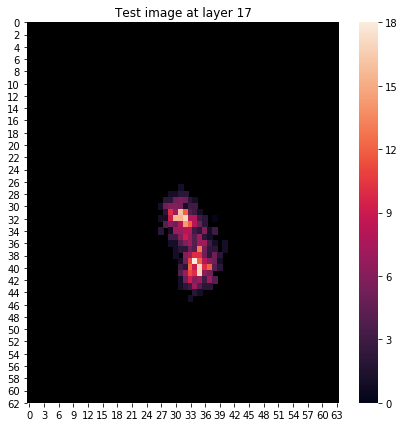

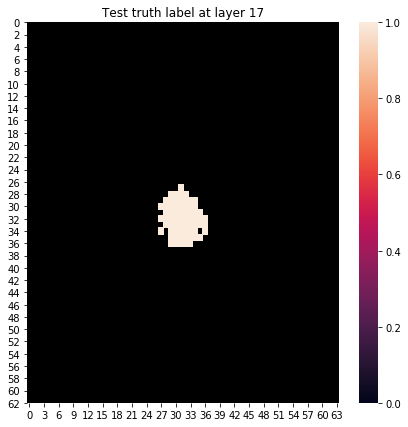

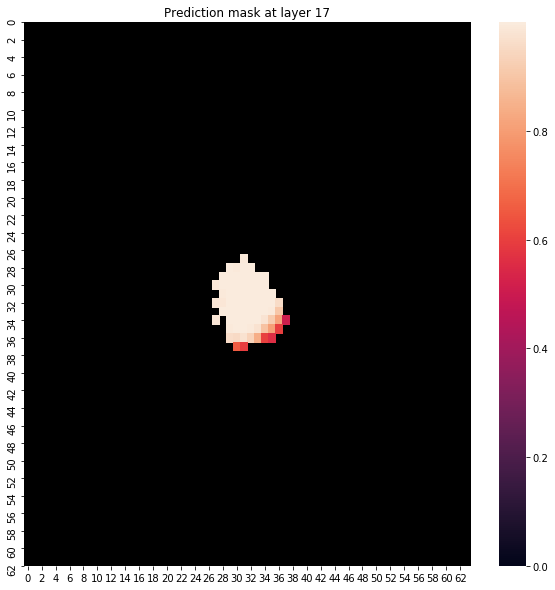

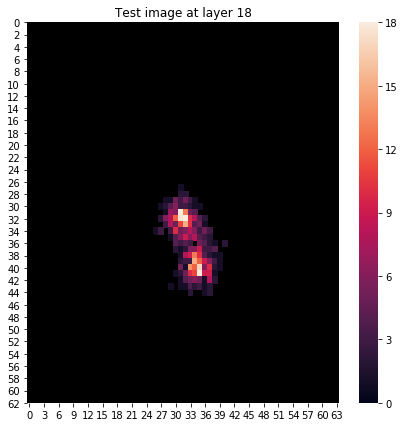

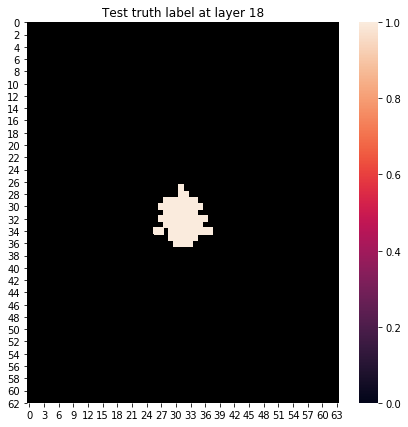

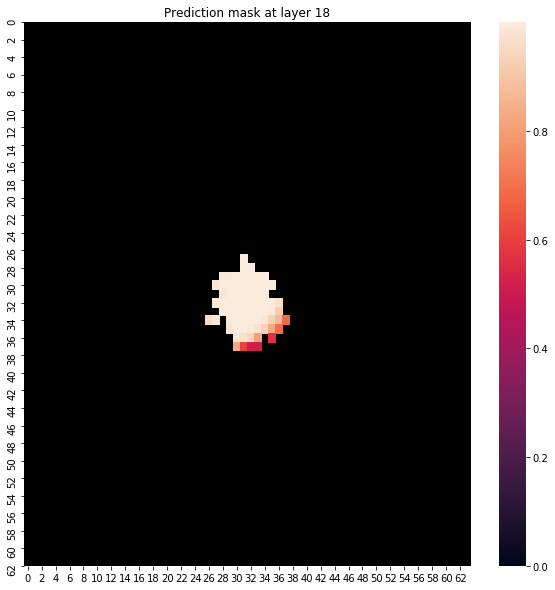

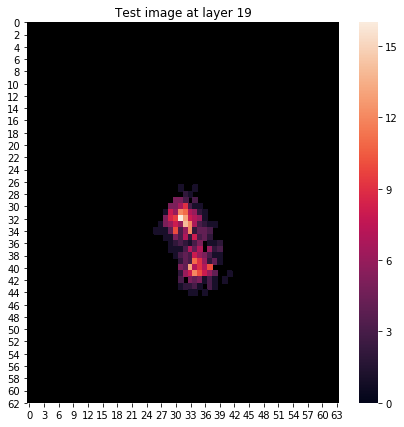

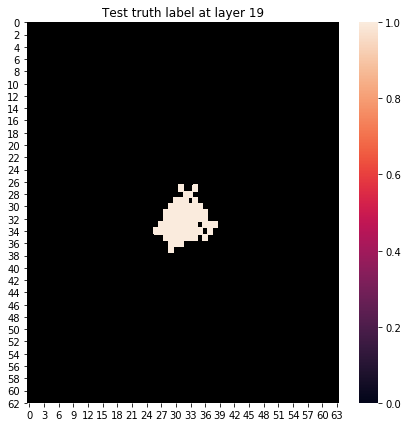

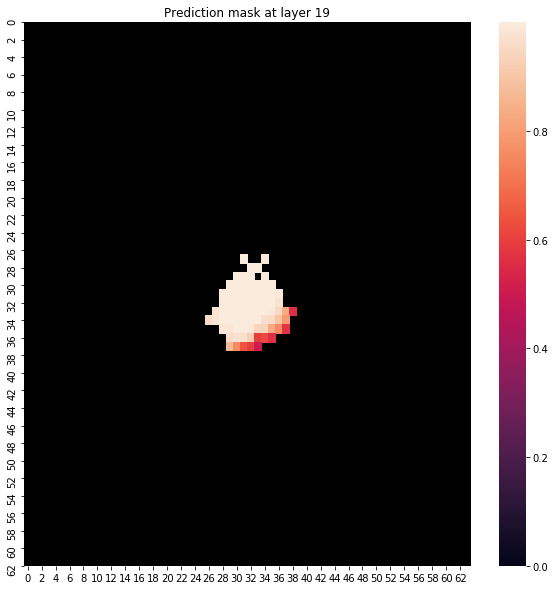

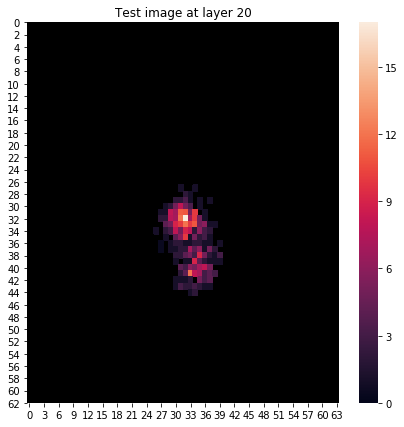

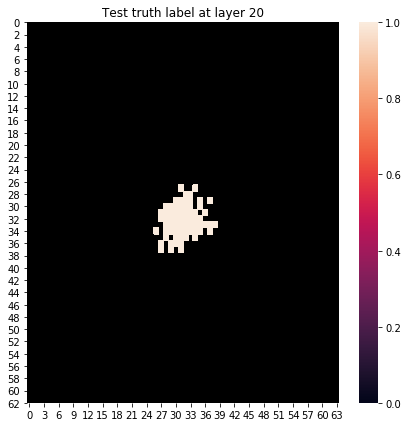

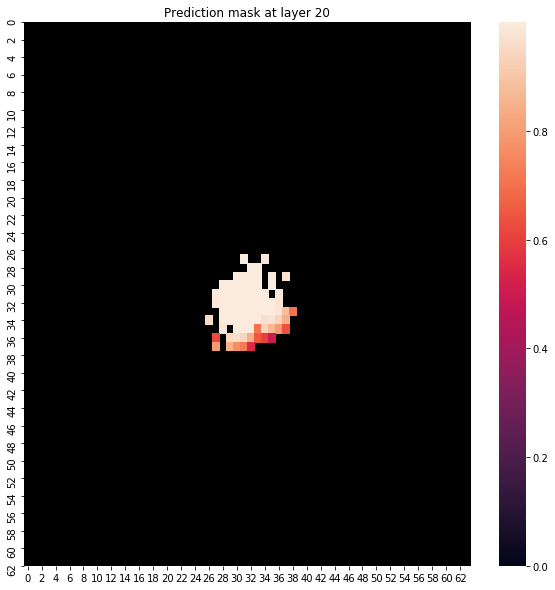

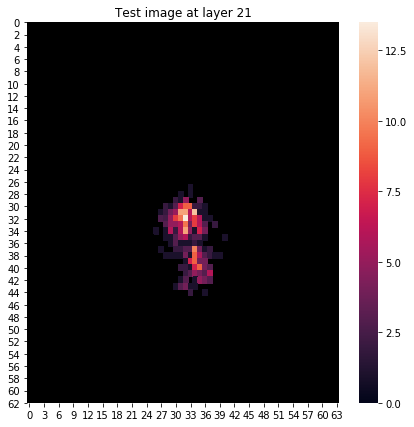

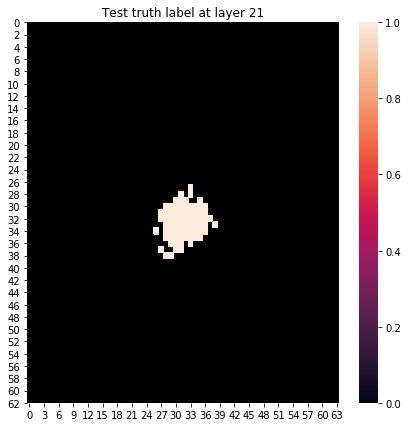

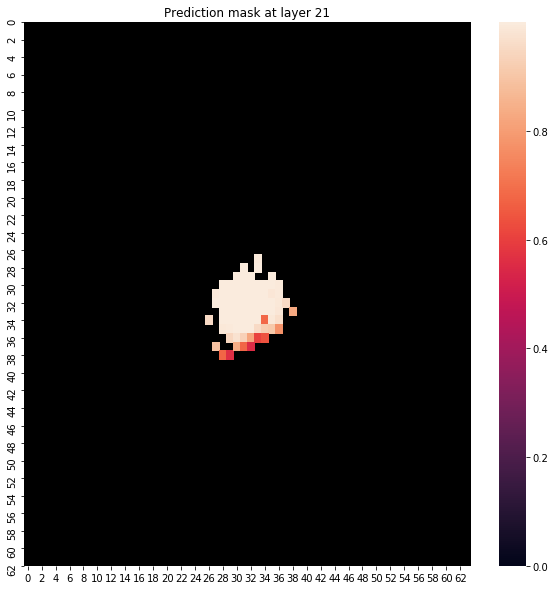

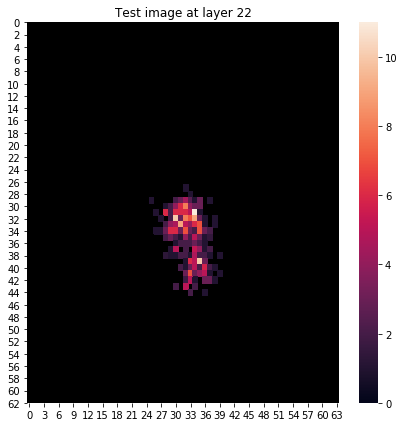

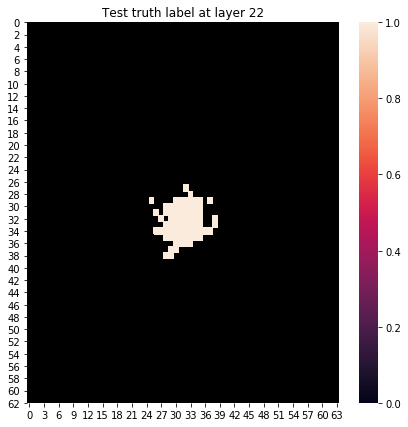

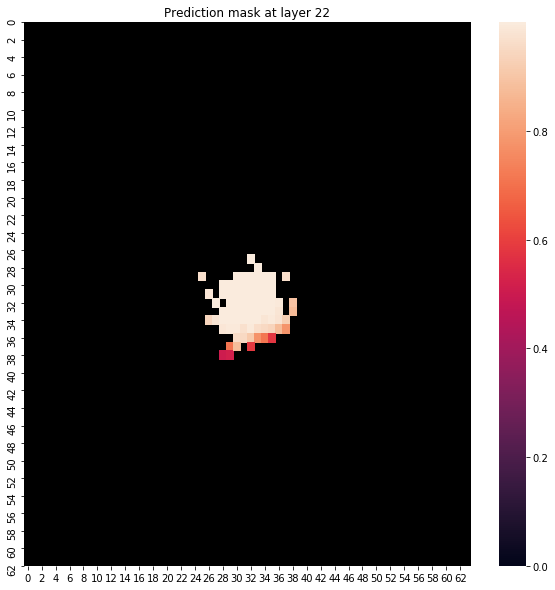

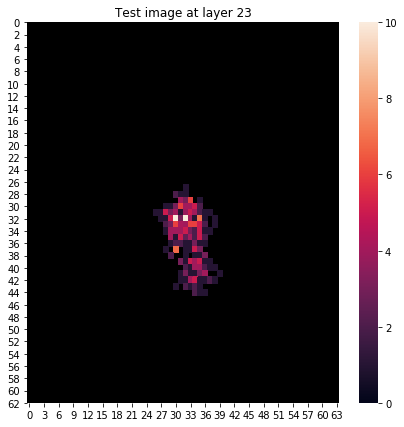

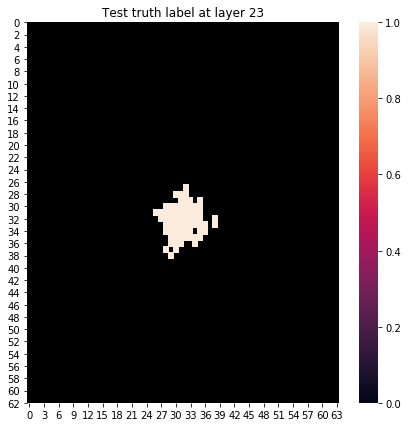

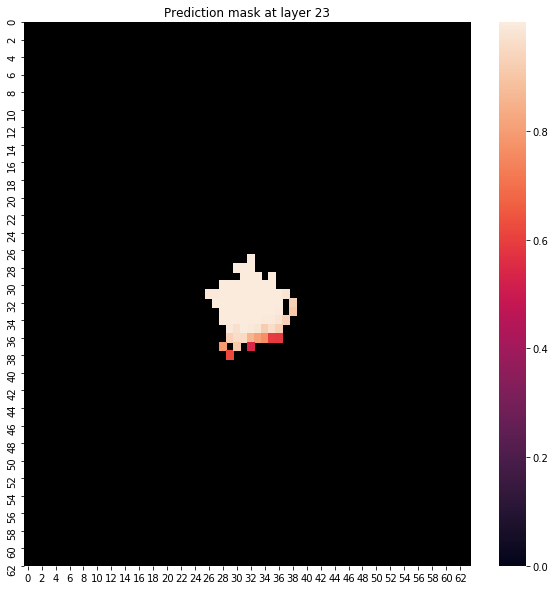

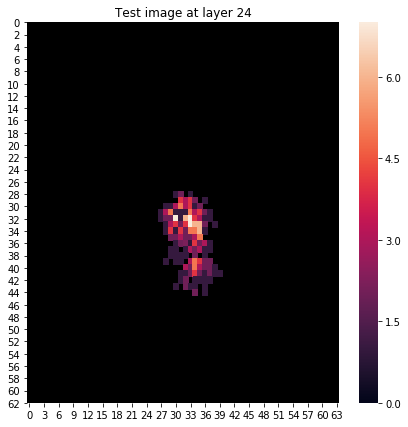

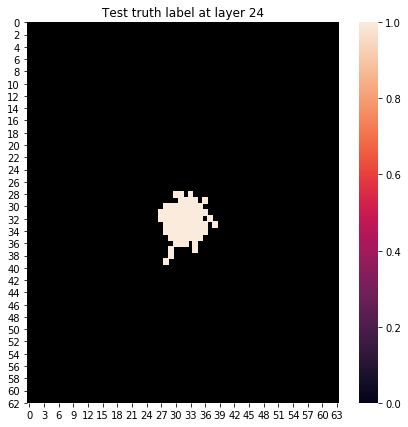

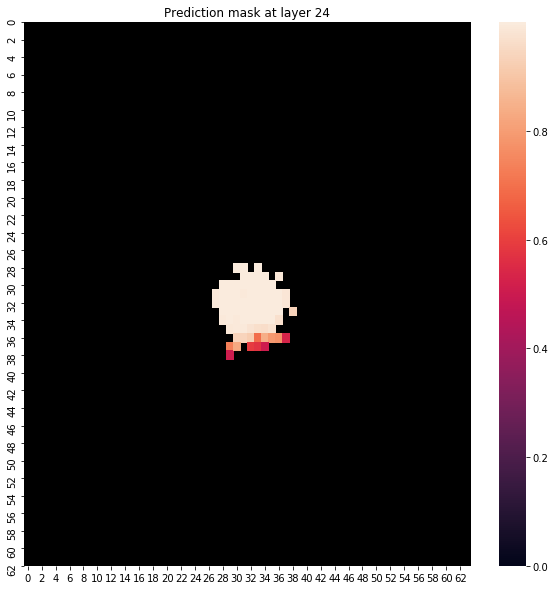

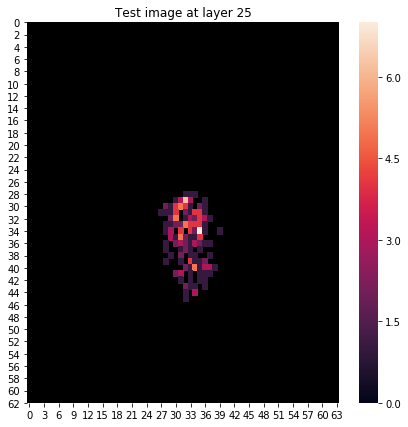

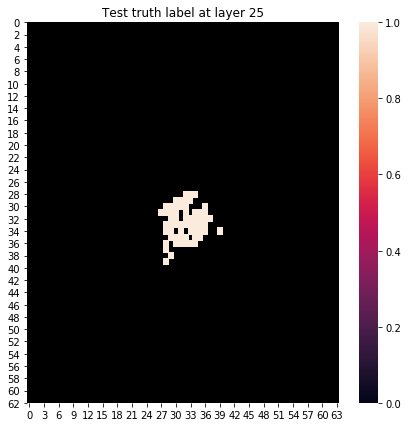

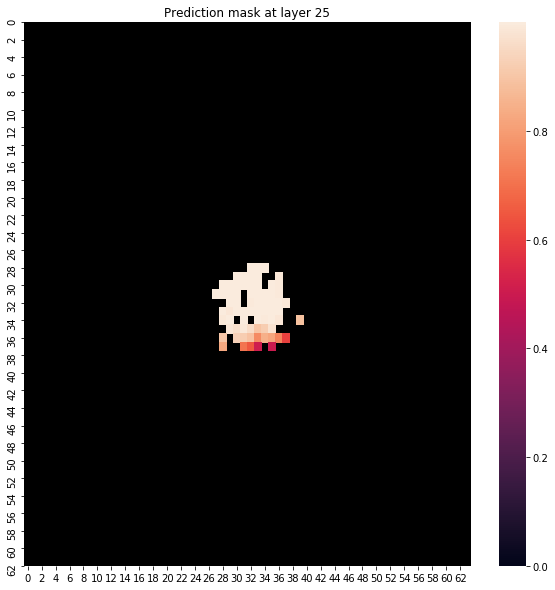

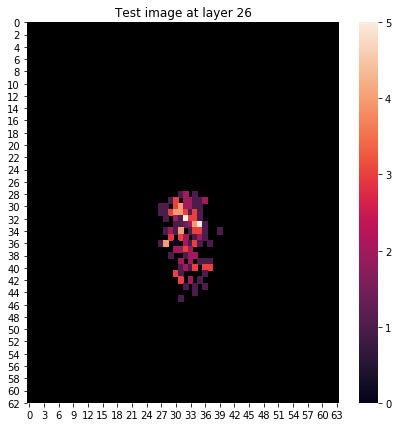

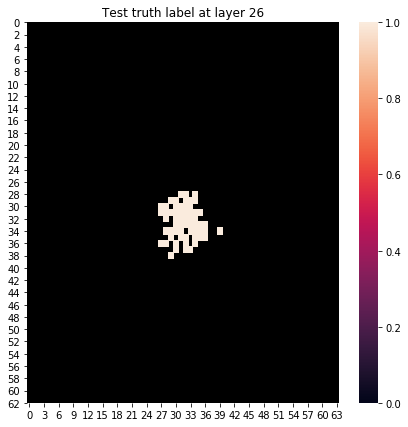

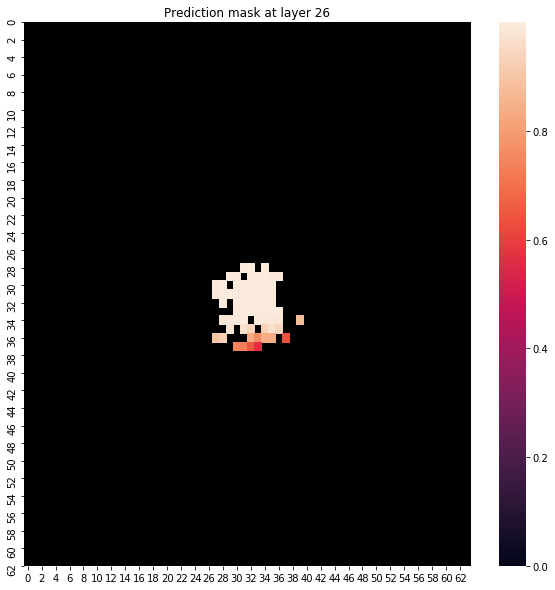

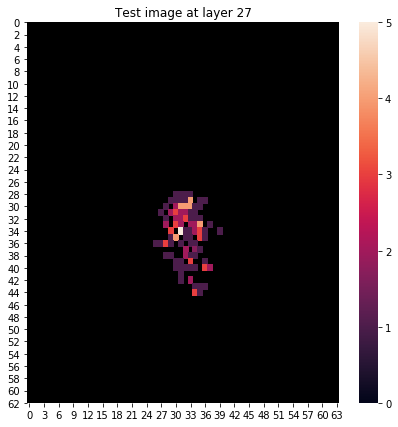

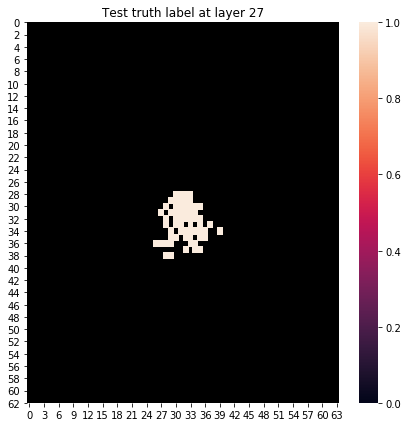

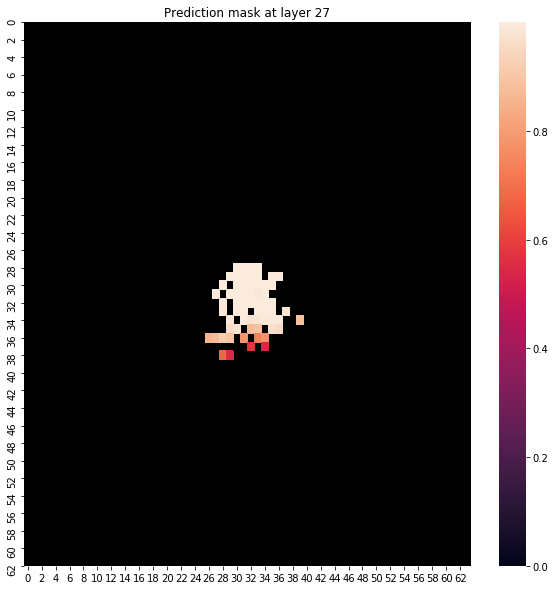

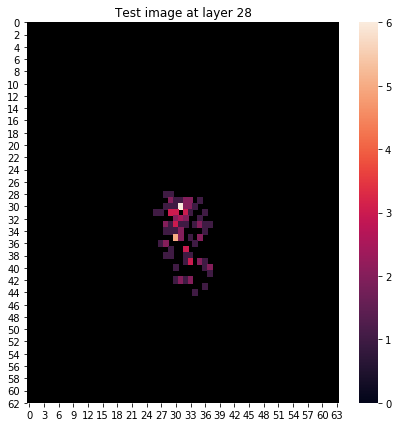

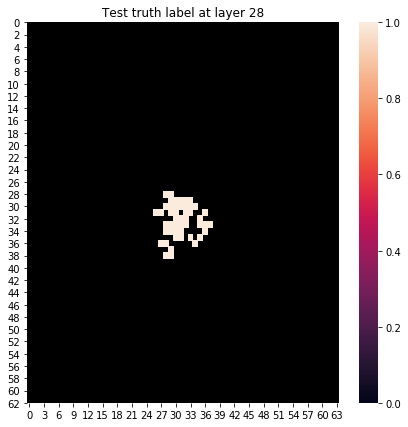

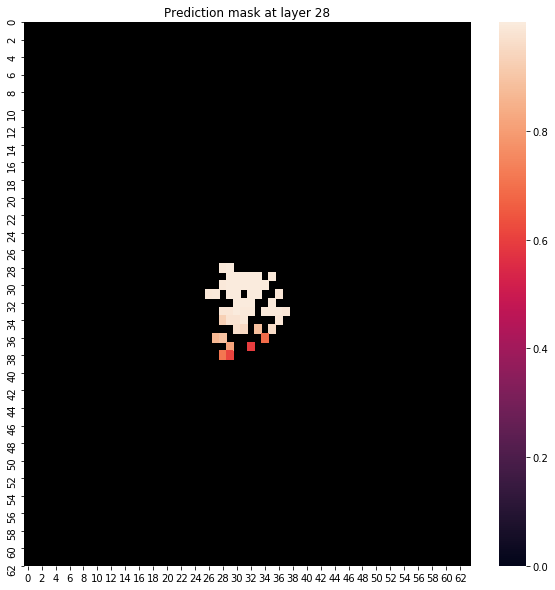

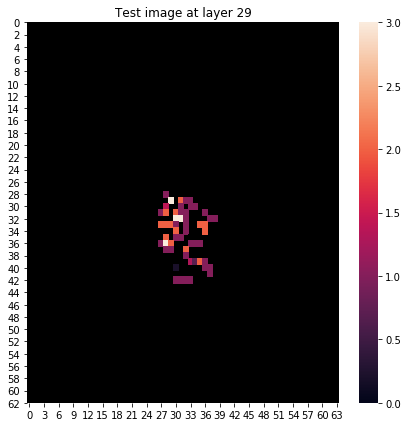

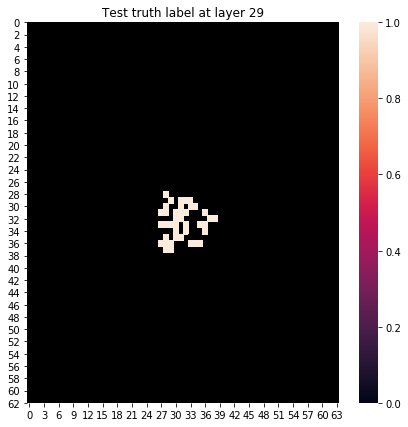

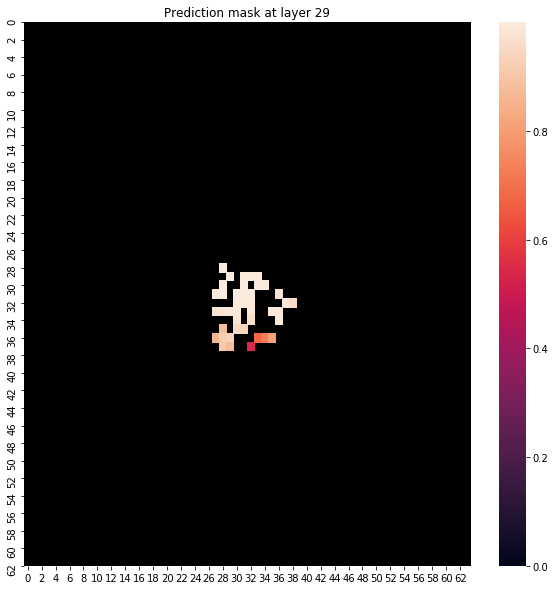

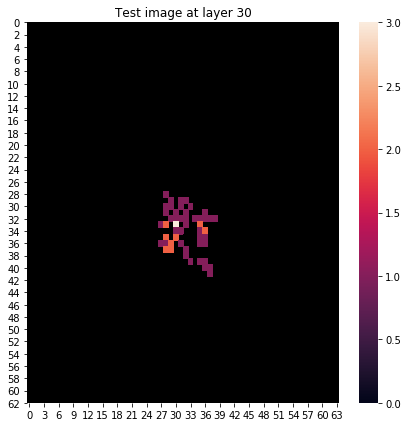

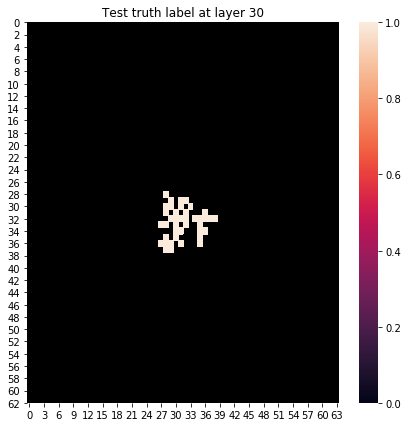

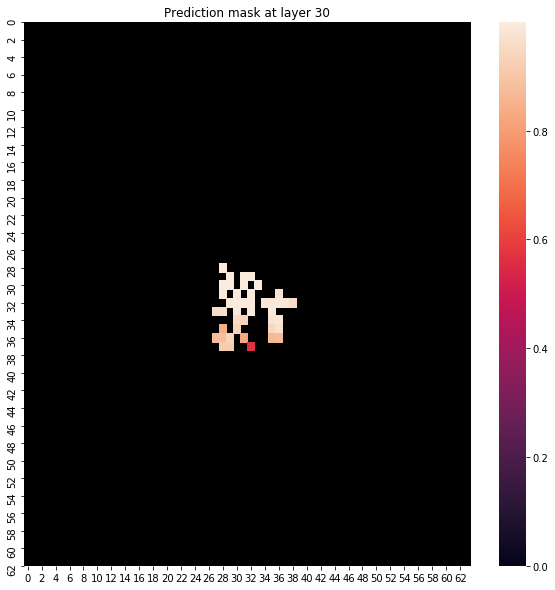

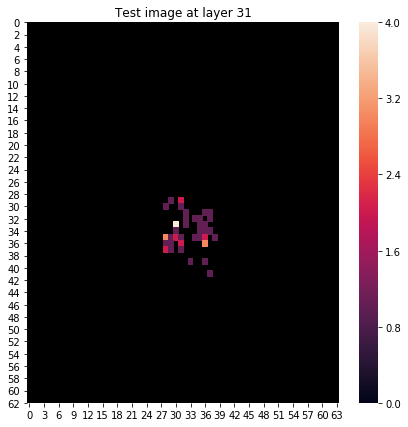

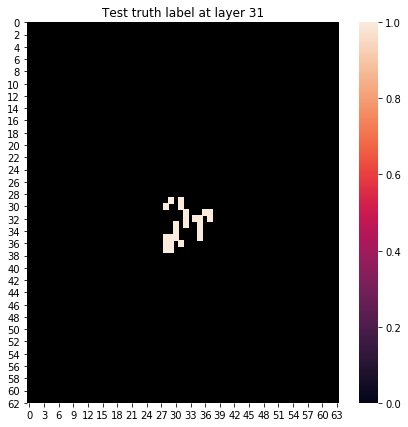

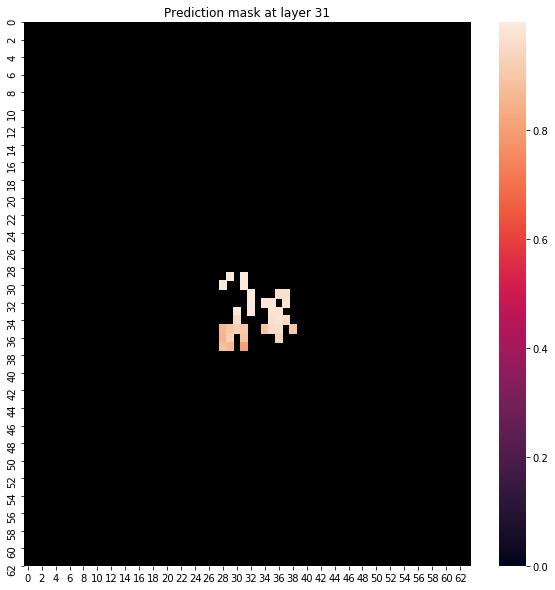

In [210]:
for lay in range(32):
    num = 0
    pred_2d = test_pred[num, lay, :, :, 0]
    label_2d = test_labels[num, lay, :, :, 0]
    image_2d = test_images[num, lay, :, :, 0]
    
    # Plot test image
    plt.figure(figsize=(7,7))
    mask = image_2d == 0.0
    ax = sns.heatmap(image_2d, mask=mask, fmt=".2")
    ax.set_facecolor("black")
    plt.title("Test image at layer %i" %(lay))
    plt.show()

    # Plot test label
    %matplotlib inline
    plt.figure(figsize=(7,7))
    mask = label_2d == 0.0
    ax = sns.heatmap(label_2d, mask=mask, fmt=".2")
    ax.set_facecolor("black")
    plt.title("Test truth label at layer %i" %(lay))
    plt.show()


    # plot prediction mask
    plt.figure(figsize=(10,10))
    mask = pred_2d < 0.5
    ax = sns.heatmap(pred_2d, mask=mask, fmt=".2",annot=False)
    ax.set_facecolor("black")
    plt.title("Prediction mask at layer %i" %(lay))
    plt.show()